In [1]:
import datetime as dt
import os
import re

from dotenv import load_dotenv
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import sqlalchemy
from sqlalchemy import text

In [2]:
# load environment variables
load_dotenv(dotenv_path='../.env')

# connection parameters
user = os.environ.get('DB_USER')
password = os.environ.get('DB_PASS')
host = os.environ.get('HOST')
port = os.environ.get('DB_PORT')
database = os.environ.get('DB_NAME')
url = f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}'

engine = sqlalchemy.create_engine(url)

In [3]:
query = 'select * from races'
race_df = pd.read_sql_query(sql=text(query), con=engine.connect())

In [4]:
read_race_results = 'select * from race_results'
race_results_df = pd.read_sql_query(sql=text(read_race_results), con=engine.connect())

In [5]:
merge_df = pd.merge(race_df, race_results_df, on='id', how='left')
merge_df = merge_df.dropna(subset=["id"])

In [6]:
USE_COLUMNS = [
    "id", "race_name", "race_place", "number_of_entries", "race_state", "date",
    "rank", "box", "horse_order", "sex_and_age", "burden_weight",
    "jockey", "horse_weight", "horse_trainer", "horse_owner"
]

use_df = merge_df[USE_COLUMNS]

In [7]:
def get_race_state_features(df):
    return_df = df.copy()
    return_df["race_course"] = df["race_state"].str[1]
    return_df["race_distance"] = df["race_state"].str[2:6]
    return_df["race_weather"] = df["race_state"].str[15]
    return_df["race_state"] = df["race_state"].str[23]
    return_df["race_start"] =  df["race_state"].str[32:37].str.replace(":", "")
    return return_df

In [8]:
def get_sex_and_age(df):
    return_df = df.copy()
    return_df["sex"] = return_df["sex_and_age"].str[0]
    return_df["age"] = return_df["sex_and_age"].str[1]
    return return_df

In [9]:
def get_horse_weight(df):
    return_df = df.copy()
    return_df["difference_weight"] = return_df["horse_weight"].str[3:]
    return_df["difference_weight"] = return_df["difference_weight"].replace(re.compile("\(|\)"), "", regex=True)
    return_df[return_df['difference_weight'] == ''] = -9999
    return_df["difference_weight"] = return_df["difference_weight"].astype(int)
    return_df[return_df['difference_weight'] == -9999] = None
    return_df["horse_weight"] = return_df["horse_weight"].str[0:3]
    return return_df

In [10]:
def get_date(df):
    return_df = df.copy()
    return_df['date'] = return_df['date'].str.split(' ', expand=True)[0]
    return_df['date'] = pd.to_datetime(return_df['date'], format='%Y年%m月%d日')
    return_df['day_of_year'] = return_df['date'].dt.day_of_year
    return_df['date_cos'] = np.cos(2 * np.pi * return_df['day_of_year'] / return_df['day_of_year'].max())
    return_df['date_sin'] = np.sin(2 * np.pi * return_df['day_of_year'] / return_df['day_of_year'].max())
    return return_df

In [11]:
def get_all_feature(df):
    return_df = df.copy()
    return_df = get_race_state_features(return_df)
    return_df = get_sex_and_age(return_df)
    return_df = get_horse_weight(return_df)
    return_df = get_date(return_df)
    return return_df

In [12]:
def label_encoder(df, cols):
    return_df = df.copy()
    for col in cols:
        le = preprocessing.LabelEncoder()
        return_df[col] = pd.Series(le.fit_transform(return_df[col]))
    return return_df

In [13]:
ENCODING_COLUMNS = [
    "race_name", "race_place",
    "race_state", "race_course", "race_weather",
    "sex_and_age", "sex",
    "jockey", "horse_trainer", "horse_owner"
]

df = get_all_feature(use_df)
encoded_df = label_encoder(df, ENCODING_COLUMNS)

In [14]:
INT_COLUMNS = [
    "box", "horse_order", "horse_weight", "race_distance",
    "race_start", "age"
]
FLOAT_COLUMNS =[
    "id", "burden_weight"
]

def clean_df(df, int_columns, float_columns):
    return_df = df.copy()
    # return_df = return_df.drop('date', axis=1)
    for col in int_columns:
        return_df[col] = pd.to_numeric(return_df[col], errors='coerce',downcast='integer')
    for col in float_columns:
        return_df[col] = return_df[col].astype(float)
    return return_df

In [15]:
clean_df = clean_df(encoded_df, INT_COLUMNS, FLOAT_COLUMNS)

In [16]:
def split_df(df):
    return_df = df.copy()
    train_df = return_df[return_df['date'] < dt.datetime(2021, 1,1)].drop('date', axis=1)
    val_df = return_df[(return_df['date'] >= dt.datetime(2021, 1,1)) & (return_df['date'] < dt.datetime(2022, 1,1))].drop('date', axis=1)
    test_df = return_df[return_df['date'] > dt.datetime(2022, 1, 1)].drop('date', axis=1)

    return train_df, val_df, test_df

In [17]:
train_df, val_df, test_df = split_df(clean_df)

In [18]:
def split_target(df):
    return_df = df.copy()
    X = return_df.drop('rank', axis=1)
    y = return_df['rank']
    y = y.replace({'1': 1, '2': 1, '3': 1})
    y[y != 1] = 0
    y = y.astype(int)
    return X, y

In [19]:
X_train, y_train = split_target(train_df)
X_val, y_val = split_target(val_df)
X_test, y_test = split_target(test_df)

In [20]:
train_set = lgbm.Dataset(X_train, y_train)
val_set = lgbm.Dataset(X_val, y_val)

params = {
    "objective": "binary",
    "metric": "auc",
    'boosting_type': 'gbdt',
    'n_estimators': 10000,
    'random_state': 74,
}

clf = lgbm.LGBMClassifier(**params)

clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        callbacks=[lgbm.early_stopping(stopping_rounds=100, verbose=True), lgbm.log_evaluation(10)])

y_pred = clf.predict(X_test)
score = roc_auc_score(y_test, y_pred)
print(f'TEST_AUC={score}')

Training until validation scores don't improve for 100 rounds
[10]	training's auc: 0.705258	valid_1's auc: 0.680209
[20]	training's auc: 0.726887	valid_1's auc: 0.69105
[30]	training's auc: 0.740582	valid_1's auc: 0.69581
[40]	training's auc: 0.753761	valid_1's auc: 0.698642
[50]	training's auc: 0.764396	valid_1's auc: 0.698983
[60]	training's auc: 0.773542	valid_1's auc: 0.699469
[70]	training's auc: 0.782089	valid_1's auc: 0.699498
[80]	training's auc: 0.790135	valid_1's auc: 0.699714
[90]	training's auc: 0.797656	valid_1's auc: 0.699563
[100]	training's auc: 0.804985	valid_1's auc: 0.69915
[110]	training's auc: 0.811039	valid_1's auc: 0.698096
[120]	training's auc: 0.816674	valid_1's auc: 0.697998
[130]	training's auc: 0.822625	valid_1's auc: 0.698341
[140]	training's auc: 0.828686	valid_1's auc: 0.698028
[150]	training's auc: 0.833458	valid_1's auc: 0.698124
[160]	training's auc: 0.839055	valid_1's auc: 0.698764
[170]	training's auc: 0.844521	valid_1's auc: 0.698904
Early stopping,

[[7990  272]
 [2179  361]]


<Axes: >

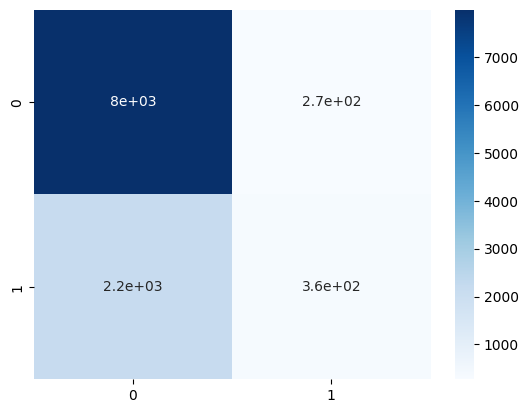

In [21]:
cm = confusion_matrix(y_test, y_pred)

print(cm)
sns.heatmap(cm, annot=True, cmap='Blues')

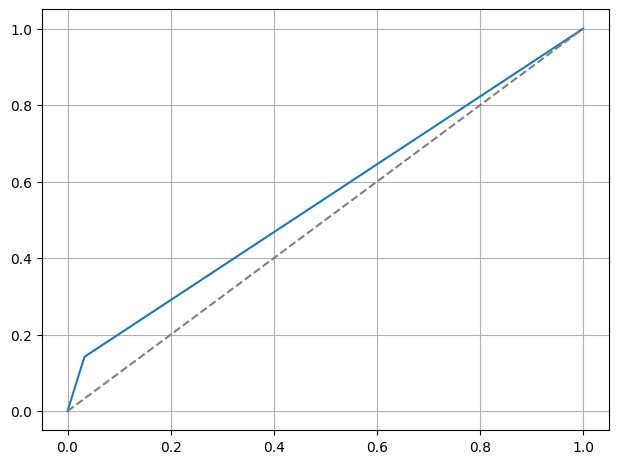

In [22]:
fig, ax = plt.subplots()

fpr, tpr, _ = roc_curve(y_test, y_pred)
ax.grid()
fig.tight_layout()
ax.plot(fpr, tpr)

ax.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='grey')